# The spread of COVID-19 conspiracy theories on social media and the effect of content moderation



**Define the path to the files:**

In [ ]:
%cd /content/COVID19_conspiracy_theories

/content/COVID19_conspiracy_theories


In [ ]:
path = "/content/COVID19_conspiracy_theories/"

Necessary libraries:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pickle

import matplotlib.colors as mcolors
import matplotlib.ticker as ticker 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

!pip install tick
from tick.dataset import fetch_hawkes_bund_data
from tick.hawkes import HawkesConditionalLaw
from tick.plot import plot_hawkes_kernel_norms
from tick.plot import plot_hawkes_kernels
from tick.hawkes import HawkesSumGaussians, HawkesEM, HawkesSumExpKern, HawkesExpKern

from google.colab import drive
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 10.8MB 4.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 


In [ ]:
%matplotlib inline

# Coding

We used the following coding for missinformation and source credibility:

* **Missinformation**:


0.   neutral or debunking content
1.   content reinforcing conspiracy theories


* **Source Credibility**:


0.   mainstream
1.   alternative
2.   other

* **Banning:**



  *   **R** Removed
  *   **F** Fact Check labeled








# Finding 1

In [ ]:
with open(path + 'url_timestamps.pickle', 'rb') as handle:
    df_multiplatform = pickle.load(handle)

In [ ]:
df_multiplatform.head(10)

,misinformation,source_credibility,twitter,facebook,reddit,4chan,twitter_dt,facebook_dt,reddit_dt,4chan_dt,twitter_order,facebook_order,reddit_order,4chan_order,reddit_banned,twitter_banned,facebook_banned
0,1,1,0,1,0,0,None,[3633789.0],None,None,NaN,1.0,NaN,NaN,None,None,"19127 R Name: banned, dtype: object"
1,1,1,0,2,0,0,None,"[7759584.0, 7759389.0]",None,None,NaN,1.0,NaN,NaN,None,None,"0 N 1 N Name: banned, dtype: object"
2,0,1,0,2,0,0,None,"[4163407.0, 4163371.0]",None,None,NaN,1.0,NaN,NaN,None,None,"19128 NaN 19129 NaN Name: banned, dtype:..."
3,1,1,1,2,0,0,[5170744.0],"[4824705.0, 4990729.0]",None,None,2.0,1.0,NaN,NaN,None,"30583 R Name: banned, dtype: object","2 N 3 N Name: banned, dtype: object"
4,1,1,0,1,0,0,None,[7483764.0],None,None,NaN,1.0,NaN,NaN,None,None,"19130 N Name: banned, dtype: object"
5,0,0,0,0,0,1,None,None,None,[2696114.0],NaN,NaN,NaN,1.0,None,None,None
6,1,1,0,0,1,0,None,None,[2273265.0],None,NaN,NaN,1.0,NaN,"5345 N Name: banned, dtype: object",None,None
7,1,2,2,6,2,7,"[3013319.0, 3013916.0]","[6757460.0, 3119117.0, 6757460.0, 3119117.0, 7...","[3027094.0, 3280819.0]","[3084269.0, 3022368.0, 3077024.0, 3023357.0, 3...",1.0,4.0,3.0,2.0,"976 N 1100 R Name: banned, dtype: object","45575 R 45576 N Name: banned, dtype: object",4 N 5 N 6 NaN 7 ...
11,0,2,1,0,0,126,[5175460.0],None,None,"[5344488.0, 5253740.0, 5267990.0, 5248645.0, 5...",2.0,NaN,NaN,1.0,None,"82289 NaN Name: banned, dtype: object",None
12,0,0,0,1,0,314,None,[2827698.0],None,"[3093249.0, 5575670.0, 4889393.0, 4864542.0, 2...",NaN,2.0,NaN,1.0,None,None,"40503 NaN Name: banned, dtype: object"


In [ ]:
def get_trajectories(list_of_platforms, regexp_misinformation, regexp_source):

  id_lists = []

  if "twitter" in list_of_platforms:
    id_lists.append(3)

  if "facebook" in list_of_platforms:
    id_lists.append(4)

  if "reddit" in list_of_platforms:
    id_lists.append(5)

  if "4chan" in list_of_platforms:
    id_lists.append(6)

  df_multiplatform_ =  df_multiplatform[df_multiplatform[df_multiplatform.iloc[:,id_lists] > 0].count(axis=1) > (len(id_lists) -1)]  
  df_trajectories = df_multiplatform_[["misinformation","source_credibility","twitter_dt", "facebook_dt", "reddit_dt", "4chan_dt"]][~df_multiplatform_[["twitter_order", "facebook_order", "reddit_order", "4chan_order"]].isnull().all(1)]
  df_trajectories_mis = df_trajectories[["twitter_dt", "facebook_dt", "reddit_dt", "4chan_dt"]][df_trajectories["misinformation"].str.contains(regexp_misinformation, na = False) & df_trajectories["source_credibility"].str.contains(regexp_source, na = False)]
  df_trajectories_mis["twitter_dt"] = df_trajectories_mis["twitter_dt"].apply(lambda d: np.asarray(d , dtype=np.double)if isinstance(d, list) else [])
  df_trajectories_mis["facebook_dt"] = df_trajectories_mis["facebook_dt"].apply(lambda d: np.asarray(d , dtype=np.double) if isinstance(d, list) else [])
  df_trajectories_mis["reddit_dt"] = df_trajectories_mis["reddit_dt"].apply(lambda d: np.asarray(d , dtype=np.double) if isinstance(d, list) else [])
  df_trajectories_mis["4chan_dt"] = df_trajectories_mis["4chan_dt"].apply(lambda d: np.asarray(d , dtype=np.double) if isinstance(d, list) else [])

  dt_lists = [name + "_dt" for name in list_of_platforms]

  trajectories = df_trajectories_mis[dt_lists].values.tolist()

  if "twitter" in list_of_platforms:
    minimum = 1901000
  else:
    res = [min(l)  for q in trajectories for l in q]    
    minimum = min(res)
  trajectories_normalized = []
  for url in trajectories:
    list_of_platforms = []
    for platform in url:
      platform_ = platform[platform >= minimum] 
      plarform__ = (platform_ - minimum)/60
      list_of_platforms.append(plarform__)
    trajectories_normalized.append(list_of_platforms)

  return(trajectories_normalized)

In [ ]:
platform_list = ["facebook","twitter","reddit","4chan"]

def hawkes_process_calculation(misinformation_rgx):
    platform_combinations = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

    amplitudes = np.arange(16.0).reshape(4,4)
    amplitudes_combination = []
    for combination in platform_combinations: 
          platform_c = [platform_list[combination[0]], platform_list[combination[1]]]
          trajectories_all = get_trajectories(platform_c, regexp_misinformation = misinformation_rgx, regexp_source="0|1|2" )
          length = len(trajectories_all)
          decays = [[0.000000001],[0.00000001],[0.0000001],[0.000001],[0.00001],[0.00005], [0.0001], [0.0002],[0.0003],[0.0004], [0.0005], [0.001], [0.002], [0.003], [0.004], [0.005], [0.006], [0.007], [0.008], [0.009], [0.01]]
          c_values = [0.1]
          scores = []
          c_val = []
          max_a = []
          learners = []
          for c_ in c_values: 
            for decay in decays:
              learner = HawkesSumExpKern(decay, penalty='l2', C=c_)
              learner.fit(trajectories_all[:int(0.8*length)])
              score = learner.score(trajectories_all[int(0.8*length):])
              if np.max(learner.adjacency)*decay[0] < decay[0] and np.max(learner.adjacency) <= 1:
                scores.append(score)
                c_val.append(c_)
                max_a.append(np.max(learner.adjacency))
                learners.append(learner)

          best_decay = decays[scores.index(max(scores))]
          best_c = c_val[scores.index(max(scores))]
          max_a_ = max_a[scores.index(max(scores))]
          best_learner = learners[scores.index(max(scores))]
          amplitudes_combination.append((platform_c, best_learner.adjacency))
          amplitudes[combination[0]][combination[0]] = best_learner.adjacency[0][0][0]
          amplitudes[combination[0]][combination[1]] = best_learner.adjacency[0][1][0]
          amplitudes[combination[1]][combination[0]] = best_learner.adjacency[1][0][0]
          amplitudes[combination[1]][combination[1]] = best_learner.adjacency[1][1][0]

          print("best_decay: ", best_decay, "best_c: ", best_c, " score : ", max(scores), "max a: ", max_a_ )
          print(scores)
    return amplitudes

In [ ]:
%%capture capt
amplitudes_non_conspiracy = hawkes_process_calculation("0")
amplitudes_conspiracy = hawkes_process_calculation("1")

In [ ]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([c('white'),c('pink'), 0.33, c('pink'), 0.66, c('pink'), c('black')])

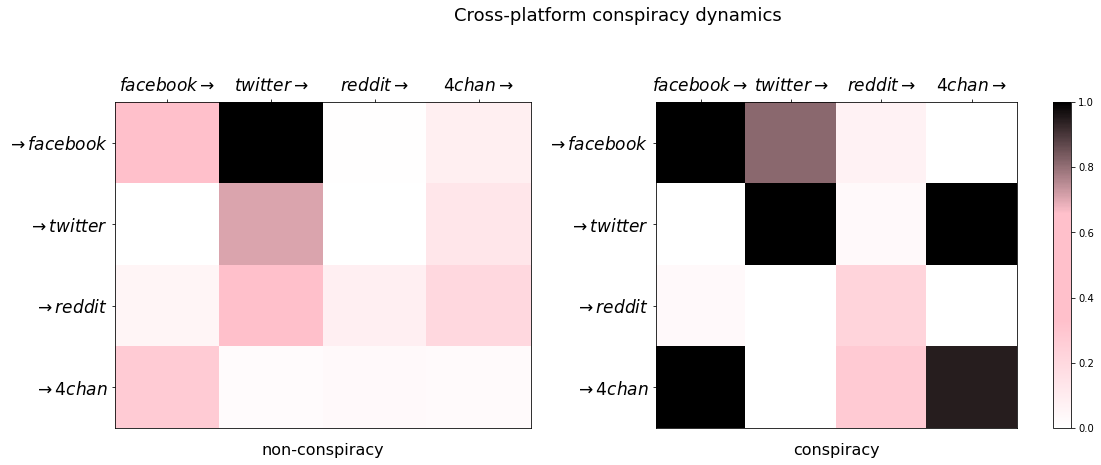

In [ ]:
pcolor_kwargs = {}
pcolor_kwargs.setdefault("cmap", rvb)
max_amp = np.max(amplitudes_conspiracy)
pcolor_kwargs.setdefault("vmin", 0)
pcolor_kwargs.setdefault("vmax", max_amp)
row_labels = ['${} \\rightarrow$'.format(i) for i in platform_list]
column_labels = ['$\\rightarrow {}$'.format(i) for i in platform_list]
x_label_alignment = 'center'
rotate_x_labels = 0.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
fig.suptitle("Cross-platform conspiracy dynamics", fontsize=18, x  = 0.9, y = 1.1)
heatmap_1 = ax[0].pcolor(amplitudes_non_conspiracy, **pcolor_kwargs)

# put the major ticks at the middle of each cell
ax[0].set_xticks(np.arange(amplitudes_non_conspiracy.shape[0]) + 0.5, minor=False)
ax[0].set_yticks(np.arange(amplitudes_non_conspiracy.shape[1]) + 0.5, minor=False)

# want a more natural, table-like display
ax[0].invert_yaxis()
ax[0].xaxis.tick_top()

ax[0].set_xticklabels(row_labels, minor=False, fontsize=17, 
                       rotation=rotate_x_labels, ha=x_label_alignment)
ax[0].set_yticklabels(column_labels, minor=False, fontsize=17)


heatmap_2 = ax[1].pcolor(amplitudes_conspiracy, **pcolor_kwargs)
# put the major ticks at the middle of each cell
ax[1].set_xticks(np.arange(amplitudes_conspiracy.shape[0]) + 0.5, minor=False)
ax[1].set_yticks(np.arange(amplitudes_conspiracy.shape[1]) + 0.5, minor=False)

# want a more natural, table-like display
ax[1].invert_yaxis()
ax[1].xaxis.tick_top()

ax[1].set_xticklabels(row_labels, minor=False, fontsize=17, 
                       rotation=rotate_x_labels, ha=x_label_alignment)
ax[1].set_yticklabels(column_labels, minor=False, fontsize=17)

fig.subplots_adjust(right=1.6, wspace=0.3)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.5)
fig.colorbar(heatmap_1, cax=cax)
ax[0].set_title('neutral or debunking content', y=-0.1, fontsize=16)
ax[1].set_title('content reinforcing conspiracy theories', y=-0.1, fontsize=16)
plt.show()

# Finding 2

In [ ]:
# buzzsumo only includes the reactions and shares for urls classified as misinformation. 
# Few urls did not appear in buzzsumo (not shared on Fb/twitter) and are missing here too
df_buzzsumo = pd.read_csv(path + "buzzsumo.csv")
df_buzzsumo.head()

,url_hash,facebook_total_reactions,twitter_shares,source_credibility
0,4,39,18,alternative
1,12,221,154,socialmedia
2,19,0,0,mainstream
3,20,47,9,mainstream
4,27,199,11000,alternative


In [ ]:
warnings.filterwarnings("ignore")

def bar_plot_extended(x_data, y_data, x_data_dots, y_data_dots, title, xlabel, color_lines, color_dots):
  fig = plt.figure(figsize=(5, 2))
  ax = fig.add_axes([0, 0, 1, 1])
  plt.hlines(y=y_data, xmin=0, xmax=x_data, color=color_lines, alpha=0.2, linewidth=20)

  # create for each expense type a dot at the level of the expense percentage value
  plt.plot(x_data_dots, y_data_dots, "o",  markersize=20, color=color_dots, alpha=1)
  plt.title(title, fontsize=12, fontweight='black', color = '#333F4B')

  # set labels style
  ax.set_xlabel(xlabel, fontsize=12, fontweight='black', color = '#333F4B')
  ax.set_ylabel('')
  # change the style of the axis spines
  ax.spines['top'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.spines['left'].set_smart_bounds(True)
  ax.spines['bottom'].set_smart_bounds(True)
  ax.spines['bottom'].set_position(('axes', -0.1))
  ax.spines['left'].set_position(('axes', 0.015))
  ax.set_ylim([-1, 3])
  plt.setp(ax.get_yticklabels(), fontweight="bold")
  plt.tight_layout() 
  plt.show()

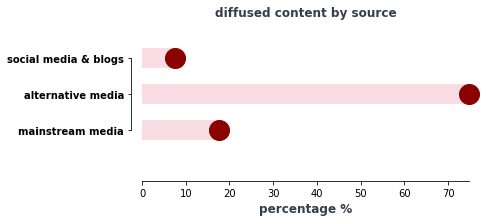

In [ ]:
mainstream_percentage = df_buzzsumo[df_buzzsumo.source_credibility == "mainstream"].shape[0] / df_buzzsumo.shape[0] * 100
alternative_percentage = df_buzzsumo[df_buzzsumo.source_credibility == "alternative"].shape[0] / df_buzzsumo.shape[0] * 100
socialmedia_percentage = df_buzzsumo[df_buzzsumo.source_credibility == "socialmedia"].shape[0] / df_buzzsumo.shape[0] * 100

source = ['mainstream media', 'alternative media', 'social media & blogs']
percent = [mainstream_percentage, alternative_percentage, socialmedia_percentage]

bar_plot_extended(percent, source, percent, source, "diffused content by source", "percentage %", "#e75480", "#8B0000")

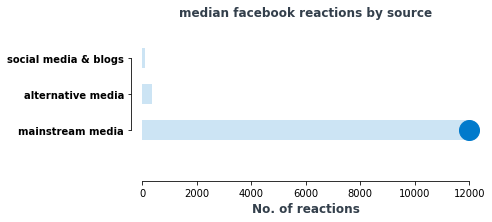

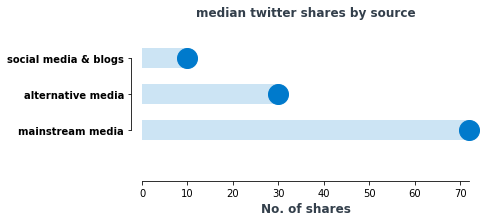

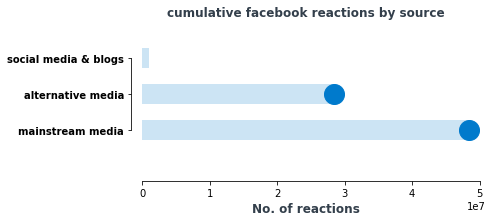

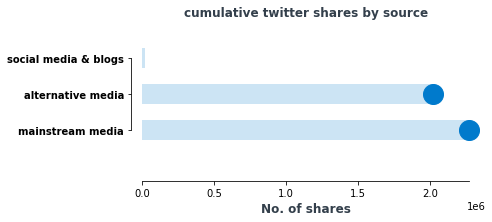

In [ ]:
fb_median = df_buzzsumo.groupby("source_credibility", as_index=False)[['facebook_total_reactions']].median()
tw_median = df_buzzsumo.groupby("source_credibility", as_index=False)[['twitter_shares']].median()
fb_sum = df_buzzsumo.groupby("source_credibility", as_index=False)[['facebook_total_reactions']].sum()
tw_sum = df_buzzsumo.groupby("source_credibility", as_index=False)[['twitter_shares']].sum()

fb_median_mainstream = fb_median[fb_median.source_credibility == "mainstream"]["facebook_total_reactions"].to_list()[0]
fb_median_alternative = fb_median[fb_median.source_credibility == "alternative"]["facebook_total_reactions"].to_list()[0]
fb_median_socialmedia = fb_median[fb_median.source_credibility == "socialmedia"]["facebook_total_reactions"].to_list()[0]

shares = [fb_median_mainstream, fb_median_alternative, fb_median_socialmedia]
bar_plot_extended(shares, source, shares[0], source[0],"median facebook reactions by source", "No. of reactions", "#007ACC", "#007ACC")

tw_median_mainstream = tw_median[tw_median.source_credibility == "mainstream"]["twitter_shares"].to_list()[0]
tw_median_alternative = tw_median[tw_median.source_credibility == "alternative"]["twitter_shares"].to_list()[0]
tw_median_socialmedia = tw_median[tw_median.source_credibility == "socialmedia"]["twitter_shares"].to_list()[0]

shares = [tw_median_mainstream, tw_median_alternative, tw_median_socialmedia]
bar_plot_extended(shares, source, shares, source,"median twitter shares by source", "No. of shares", "#007ACC", "#007ACC")

fb_sum_mainstream = fb_sum[fb_sum.source_credibility == "mainstream"]["facebook_total_reactions"].to_list()[0]
fb_sum_alternative = fb_sum[fb_sum.source_credibility == "alternative"]["facebook_total_reactions"].to_list()[0]
fb_sum_socialmedia = fb_sum[fb_sum.source_credibility == "socialmedia"]["facebook_total_reactions"].to_list()[0]

shares = [fb_sum_mainstream, fb_sum_alternative, fb_sum_socialmedia]
bar_plot_extended(shares, source, shares[0:2], source[0:2],"cumulative facebook reactions by source", "No. of reactions", "#007ACC", "#007ACC")

tw_sum_mainstream = tw_sum[tw_sum.source_credibility == "mainstream"]["twitter_shares"].to_list()[0]
tw_sum_alternative = tw_sum[tw_sum.source_credibility == "alternative"]["twitter_shares"].to_list()[0]
tw_sum_socialmedia = tw_sum[tw_sum.source_credibility == "socialmedia"]["twitter_shares"].to_list()[0]

shares = [tw_sum_mainstream, tw_sum_alternative, tw_sum_socialmedia]
bar_plot_extended(shares, source, shares[0:2], source[0:2],"cumulative twitter shares by source", "No. of shares", "#007ACC", "#007ACC")

# Finding 3

In [ ]:
def get_trajectories_moderated(list_of_platforms, regexp_misinformation, regexp_source, moderated, platform):
  
  df_multiplatform_ = df_multiplatform

  for pl in platform:
    col_banned = pl + "_banned"
    if moderated == True:
        df_multiplatform_ = df_multiplatform_[df_multiplatform_[col_banned] > 0]
    else:
        df_multiplatform_ = df_multiplatform_[df_multiplatform_[col_banned] == 0]

  id_lists = []

  if "twitter" in list_of_platforms:
    id_lists.append(3)

  if "facebook" in list_of_platforms:
    id_lists.append(4)

  if "reddit" in list_of_platforms:
    id_lists.append(5)

  if "4chan" in list_of_platforms:
    id_lists.append(6)

  df_multiplatform_ =  df_multiplatform_[df_multiplatform_[df_multiplatform_.iloc[:,id_lists] > 0].count(axis=1) > (len(id_lists) -1)]  
  df_trajectories = df_multiplatform_[["misinformation","source_credibility","twitter_dt", "facebook_dt", "reddit_dt", "4chan_dt"]][~df_multiplatform_[["twitter_order", "facebook_order", "reddit_order", "4chan_order"]].isnull().all(1)]
  df_trajectories_mis = df_trajectories[["twitter_dt", "facebook_dt", "reddit_dt", "4chan_dt"]][df_trajectories["misinformation"].str.contains(regexp_misinformation, na = False) & df_trajectories["source_credibility"].str.contains(regexp_source, na = False)]
  df_trajectories_mis["twitter_dt"] = df_trajectories_mis["twitter_dt"].apply(lambda d: np.asarray(d , dtype=np.double)if isinstance(d, list) else [])
  df_trajectories_mis["facebook_dt"] = df_trajectories_mis["facebook_dt"].apply(lambda d: np.asarray(d , dtype=np.double) if isinstance(d, list) else [])
  df_trajectories_mis["reddit_dt"] = df_trajectories_mis["reddit_dt"].apply(lambda d: np.asarray(d , dtype=np.double) if isinstance(d, list) else [])
  df_trajectories_mis["4chan_dt"] = df_trajectories_mis["4chan_dt"].apply(lambda d: np.asarray(d , dtype=np.double) if isinstance(d, list) else [])

  dt_lists = [name + "_dt" for name in list_of_platforms]

  trajectories = df_trajectories_mis[dt_lists].values.tolist()
  if "twitter" in list_of_platforms:
    minimum = 1901000
  else:
    res = [min(l)  for q in trajectories for l in q]    
    minimum = min(res)
  #print(minimum)
  trajectories_normalized = []
  for url in trajectories:
    list_of_platforms = []
    for platform in url:
      platform_ = platform[platform >= minimum] 
      plarform__ = (platform_ - minimum)/60
      list_of_platforms.append(plarform__)
    trajectories_normalized.append(list_of_platforms)

  return(trajectories_normalized)

In [ ]:
platform_list = ["twitter","facebook","reddit","4chan"]

def hawkes_process_calculation_moderation(moderation, combination, plat):
    trajectories_all = get_trajectories_moderated([platform_list[combination[0]],platform_list[combination[1]]], "1", "0|1|2", moderation, [platform_list[plat]])
    length = len(trajectories_all)
    print(length)
    decays = [[0.000000001],[0.00000001],[0.0000001],[0.000001],[0.00001],[0.00005], [0.0001], [0.0002],[0.0003],[0.0004], [0.0005], [0.001], [0.002], [0.003], [0.004], [0.005], [0.006], [0.007], [0.008], [0.009], [0.01], [0.1]]
    c_values = [0.1]
    scores = []
    c_val = []
    max_a = []
    learners = []
    for c_ in c_values: 
      for decay in decays:
        learner = HawkesSumExpKern(decay, penalty='l2', C=c_)
        learner.fit(trajectories_all[:int(0.8*length)])
        score = learner.score(trajectories_all[int(0.8*length):])
        if np.max(learner.adjacency)*decay[0] < decay[0] and np.max(learner.adjacency) <= 1:
          scores.append(score)
          c_val.append(c_)
          max_a.append(np.max(learner.adjacency))
          learners.append(learner)
  
    best_decay = decays[scores.index(max(scores))]
    best_c = c_val[scores.index(max(scores))]
    max_a_ = max_a[scores.index(max(scores))]
    best_learner = learners[scores.index(max(scores))]
    return best_learner.adjacency, best_c

In [ ]:
%%capture
platform_list = ["twitter","facebook","reddit","4chan"]
platform_combinations = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

amplitudes_combination = []

for combination in platform_combinations:
  for plat in combination:
    # 4chan is missing
    if plat == 3:
        continue
    moderated, best_c = hawkes_process_calculation_moderation(True, combination, plat)
    unmoderated, best_c_un = hawkes_process_calculation_moderation(False, combination, plat)
    amplitudes_combination.append(((platform_list[combination[0]],platform_list[combination[1]]), plat, moderated, unmoderated, best_c, best_c_un))

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
indexes = ["moderated", "unmoderated", "mod_platform"]

df_amplitudes = []
for combination in amplitudes_combination:
  amplitudes_array_moderated = combination[2].flatten()
  amplitudes_array_unmoderated = combination[3].flatten()
  names = ["%s -> %s" % (combination[0][0], combination[0][0]), "%s -> %s" % (combination[0][1], combination[0][0]), "%s -> %s" % (combination[0][0], combination[0][1]), "%s -> %s" % (combination[0][1], combination[0][1])]
  df_temp = pd.DataFrame(np.vstack((amplitudes_array_moderated,amplitudes_array_unmoderated, [platform_list[combination[1]], platform_list[combination[1]],platform_list[combination[1]],platform_list[combination[1]] ])), index=indexes, columns=names)
  df_amplitudes.append(df_temp)
  

In [ ]:
df_platforms = pd.concat([x.T for x in df_amplitudes])
df_platforms["moderated"] = df_platforms["moderated"].astype(float)
df_platforms["unmoderated"] = df_platforms["unmoderated"].astype(float)

df_platforms["p_change"] = df_platforms.apply(lambda x: (x[0]- x[1])/x[1] if x[1] != 0.0 else 1, 1)
df_platforms = df_platforms[~df_platforms.index.str.contains("^4chan", na = False)]
df_platforms["diff"] = df_platforms["moderated"] - df_platforms["unmoderated"] 
df_platforms

,moderated,unmoderated,mod_platform,p_change,diff
twitter -> twitter,0.02,0.99,twitter,-0.98,-0.97
facebook -> twitter,0.01,0.00,twitter,1.00,0.01
twitter -> facebook,0.02,0.81,twitter,-0.98,-0.80
facebook -> facebook,0.02,0.00,twitter,1.00,0.02
twitter -> twitter,0.03,1.00,facebook,-0.97,-0.97
facebook -> twitter,0.01,0.00,facebook,8.98,0.01
twitter -> facebook,0.04,0.00,facebook,1.00,0.04
facebook -> facebook,0.02,1.00,facebook,-0.98,-0.98
twitter -> twitter,0.02,0.08,twitter,-0.76,-0.06
reddit -> twitter,0.02,0.14,twitter,-0.83,-0.11


In [ ]:
df_platforms["from"], df_platforms["to"] = zip(*df_platforms.index.str.split(" -> ").tolist())
print("In-platform effects")
df_in = df_platforms[df_platforms.apply(lambda x: x["from"]==x["to"]==x["mod_platform"], 1)]
df_in.groupby("mod_platform").mean()["diff"]/df_in.groupby("mod_platform").mean()["unmoderated"]

In-platform effects


mod_platform
facebook   -0.96
reddit     -0.97
twitter    -0.10
dtype: float64

In [ ]:
print("Cross-platform effects")
df_out = df_platforms[df_platforms.apply(lambda x: (x["from"]!=x["to"]) & (x["from"]==x["mod_platform"]), 1)]
df_out.groupby("mod_platform").mean()["diff"]/df_out.groupby("mod_platform").mean()["unmoderated"]

Cross-platform effects


mod_platform
facebook   -0.99
reddit     -0.93
twitter    -0.98
dtype: float64

In [ ]:
print("Overall effects")
print("facebook", ( df_platforms[df_platforms.index.str.contains("^facebook", na = False)]["moderated"].mean()  - df_platforms[df_platforms.index.str.contains("^facebook", na = False)]["unmoderated"].mean() )/df_platforms[df_platforms.index.str.contains("^facebook", na = False)]["unmoderated"].mean())
print("reddit", ( df_platforms[df_platforms.index.str.contains("^twitter", na = False)]["moderated"].mean()  - df_platforms[df_platforms.index.str.contains("^twitter", na = False)]["unmoderated"].mean() )/df_platforms[df_platforms.index.str.contains("^twitter", na = False)]["unmoderated"].mean())
print("twitter", ( df_platforms[df_platforms.index.str.contains("^reddit", na = False)]["moderated"].mean()  - df_platforms[df_platforms.index.str.contains("^reddit", na = False)]["unmoderated"].mean() )/df_platforms[df_platforms.index.str.contains("^reddit", na = False)]["unmoderated"].mean())

Overall effects
facebook -0.9691567216256533
reddit -0.6195335425705961
twitter -0.9442188556608188


# Finding 4

In [ ]:
twitter_banned = pd.read_csv(path + "twitter_banned.csv")
facebook_banned = pd.read_csv(path + "facebook_banned.csv")
reddit_banned = pd.read_csv(path + "reddit_banned.csv")
youtube_banned = pd.read_csv(path + "youtube_banned.csv")

In [ ]:
twitter_march = twitter_banned[twitter_banned["banned_march"].isin(["R", "F"])].shape[0] / twitter_banned.shape[0] * 100
twitter_april = twitter_banned[twitter_banned["banned_april"].isin(["R", "F"])].shape[0] / twitter_banned.shape[0] * 100
facebook_march = facebook_banned[facebook_banned["banned_march"].isin(["R", "F"])].shape[0] / facebook_banned.shape[0] * 100
facebook_april = facebook_banned[facebook_banned["banned_april"].isin(["R", "F"])].shape[0] / facebook_banned.shape[0] * 100
reddit_march = reddit_banned[reddit_banned["banned_march"].isin(["R", "F"])].shape[0] / reddit_banned.shape[0] * 100
reddit_april = reddit_banned[reddit_banned["banned_april"].isin(["R", "F"])].shape[0] / reddit_banned.shape[0] * 100
youtube_march = youtube_banned[youtube_banned["banned_march"].isin(["R", "F"])].shape[0] / youtube_banned.shape[0] * 100
youtube_april = youtube_banned[youtube_banned["banned_april"].isin(["R", "F"])].shape[0] / youtube_banned.shape[0] * 100

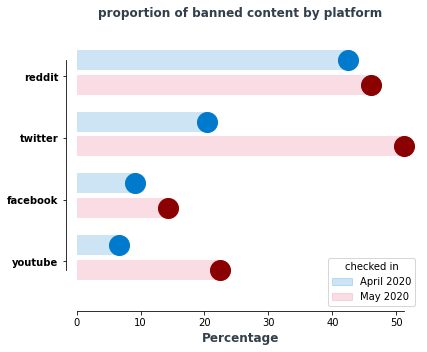

In [ ]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
source = [0, 0.6, 1.5, 2.1, 3, 3.6, 4.5, 5.1]
percent = [youtube_april, youtube_march, facebook_april, facebook_march, twitter_april, twitter_march, reddit_april, reddit_march]
plt.hlines(y=source, xmin=0, xmax=percent,colors=["#e75480", '#007ACC', "#e75480", '#007ACC', "#e75480", '#007ACC', "#e75480", '#007ACC'], alpha=0.2, linewidth=20)
plt.yticks([0.2, 1.7, 3.2, 4.7],['youtube', 'facebook', 'twitter', 'reddit'])


# create for each expense type a dot at the level of the expense percentage value
colors = ['#8B0000', '#007ACC', '#8B0000', '#007ACC', '#8B0000', '#007ACC', '#8B0000', '#007ACC']
for i,_ in enumerate(percent):
  plt.plot(percent[i], source[i], "o",color=colors[i], markersize=20, alpha=1)

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='#e75480', alpha=0.2, label='May 2020')
blue_patch = mpatches.Patch(color='#007ACC', alpha=0.2, label='April 2020')

plt.legend(handles=[blue_patch, red_patch], title="checked in", loc=4, fancybox=True)

plt.title("proportion of banned content by platform", fontsize=12, fontweight='black', color = '#333F4B')

# set labels style
ax.set_xlabel('Percentage', fontsize=12, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['bottom'].set_position(('axes', 0.0))
ax.spines['left'].set_position(('axes', 0.015))
ax.set_ylim([-1,6])
plt.setp(ax.get_yticklabels(), fontweight="bold")
plt.tight_layout() 
plt.show()


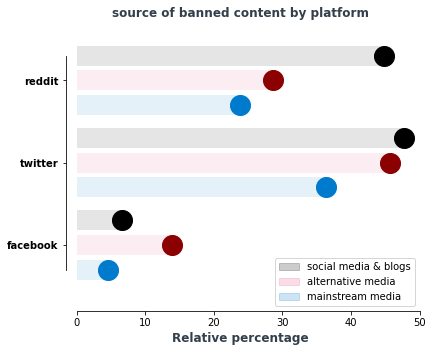

In [ ]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])
source = [0,0.6,1.2, 2,2.6,3.2, 4,4.6,5.2]
percent = [4.617117117117117, 13.967258794845003, 6.6543438077634, 36.27535143255714, 45.72227510709186, 47.68133174791914, 23.809523809523808, 28.57142857142857, 44.742729306487694]


plt.hlines(y=source, xmin=0, xmax=percent,colors=['#007ACC',"#e75480","#000000",'#007ACC',"#e75480","#000000",'#007ACC',"#e75480","#000000"], alpha=0.1, linewidth=20)
plt.yticks([0.6,2.6,4.6],['facebook', 'twitter', 'reddit'])


# create for each expense type a dot at the level of the expense percentage value
colors = ['#007ACC','#8B0000','#000000','#007ACC','#8B0000','#000000','#007ACC','#8B0000','#000000']
for i,_ in enumerate(percent):
  plt.plot(percent[i], source[i], "o",color=colors[i], markersize=20, alpha=1)

import matplotlib.patches as mpatches

black_patch = mpatches.Patch(color='#000000', alpha=0.2, label='social media & blogs')
red_patch = mpatches.Patch(color='#e75480', alpha=0.2, label='alternative media')
blue_patch = mpatches.Patch(color='#007ACC', alpha=0.2, label='mainstream media')

plt.legend(handles=[black_patch, red_patch,blue_patch], loc=4, fancybox=True)

#ax.bar(source,percent)
plt.title("source of banned content by platform", fontsize=12, fontweight='black', color = '#333F4B')

# set labels style
ax.set_xlabel('Relative percentage', fontsize=12, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['bottom'].set_position(('axes', 0.0))
ax.spines['left'].set_position(('axes', 0.015))
ax.set_ylim([-1,6])
plt.setp(ax.get_yticklabels(), fontweight="bold")
plt.tight_layout() 
plt.show()